# Hops Feature Selection
* StellarAlgo Data Science
* Ryan Kazmerik & Nakisa Rad
* October 27, 2021

## Hypothesis
Write about the hunch you have and why you're running this experiment.

## Experiment
Document the experiment including selecting data, data transformations, feature engineering and modelling

In [1]:
import getpass
import pyodbc
import pandas as pd
import warnings
from pycaret.classification import *
from ngboost import NGBClassifier

warnings.filterwarnings('ignore')

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [2]:
SERVER = '34.206.73.189' 
DATABASE = 'datascience' 
USERNAME = 'nrad' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

Enter your password········


In [3]:
lkupclientid = 9 # hops

cursor = CNXN.cursor()

storedProc = (
    f"""Exec [stlrMILB].[ds].[getRetentionScoringModelData] {lkupclientid}"""
)

df = pd.read_sql(storedProc, CNXN)

CNXN.commit()
cursor.close()

df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 55 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   lkupClientId              7173 non-null   int64  
 1   dimCustomerMasterId       7173 non-null   int64  
 2   customerNumber            7173 non-null   object 
 3   year                      7173 non-null   object 
 4   productGrouping           7173 non-null   object 
 5   totalSpent                7173 non-null   float64
 6   recentDate                7173 non-null   object 
 7   attendancePercent         7173 non-null   float64
 8   renewedBeforeDays         7173 non-null   int64  
 9   isBuyer                   7173 non-null   object 
 10  source_tenure             7173 non-null   int64  
 11  tenure                    7173 non-null   int64  
 12  distToVenue               7173 non-null   float64
 13  totalGames                7173 non-null   int64  
 14  recency 

### Let's drop the features that have lots of null values:

In [4]:
df.drop([ 
    'lengthOfResidenceInYrs',
    'annualHHIncome',
    'education',
    'urbanicity',
    'isnextyear_buyer',
    'isnextyear_samepkg_buyer',
    'pkgupgrade_status',
    'auto_renewal'],
    axis=1, 
    inplace=True
)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 47 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   lkupClientId          7173 non-null   int64  
 1   dimCustomerMasterId   7173 non-null   int64  
 2   customerNumber        7173 non-null   object 
 3   year                  7173 non-null   object 
 4   productGrouping       7173 non-null   object 
 5   totalSpent            7173 non-null   float64
 6   recentDate            7173 non-null   object 
 7   attendancePercent     7173 non-null   float64
 8   renewedBeforeDays     7173 non-null   int64  
 9   isBuyer               7173 non-null   object 
 10  source_tenure         7173 non-null   int64  
 11  tenure                7173 non-null   int64  
 12  distToVenue           7173 non-null   float64
 13  totalGames            7173 non-null   int64  
 14  recency               7173 non-null   int64  
 15  missed_games_1       

### In order to compare two sets of features, we need to create some datasets for training and evalution:

In [5]:
df_train_A = df.sample(frac=0.9, random_state=786)
df_train_B = df.sample(frac=0.9, random_state=786)

df_eval_A = df.drop(df_train_A.index)
df_eval_B = df.drop(df_train_B.index)

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

print('Data for Modeling (A Class): ' + str(df_train_A.shape))
print('Unseen Data For Predictions: ' + str(df_eval_A.shape))

Data for Modeling (A Class): (6456, 47)
Unseen Data For Predictions: (717, 47)
Data for Modeling (A Class): (6456, 47)
Unseen Data For Predictions: (717, 47)


### Let's also drop the features that only have a single value, as they won't add much differentiation to our model:

In [6]:
for col in df.columns:
    if len(df[col].unique()) == 1:
        df.drop(col,inplace=True,axis=1)
        
df.shape

(7173, 24)

### We should also drop features that have a low correlation with the target label as they won't be useful for prediction, we'll only keep features that have a correlation above a set threshold:

In [7]:
cor = df.corr()

threshold = 0.05

#Correlation with output variable
cor_target = abs(cor["isNextYear_Buyer"])

#Selecting highly correlated features
relevant_features = cor_target[cor_target > threshold]

feats = []
for name, val in relevant_features.items():
    feats.append(name)

df_correlated = df[feats]

df_correlated.shape

df_correlated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7173 entries, 0 to 7172
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   dimCustomerMasterId  7173 non-null   int64  
 1   totalSpent           7173 non-null   float64
 2   attendancePercent    7173 non-null   float64
 3   renewedBeforeDays    7173 non-null   int64  
 4   distToVenue          7173 non-null   float64
 5   totalGames           7173 non-null   int64  
 6   missed_games_1       7173 non-null   int64  
 7   missed_games_2       7173 non-null   int64  
 8   missed_games_over_2  7173 non-null   int64  
 9   click_link           7173 non-null   int64  
 10  open_email           7173 non-null   int64  
 11  send_email           7173 non-null   int64  
 12  openToSendRatio      7173 non-null   float64
 13  clickToSendRatio     7173 non-null   float64
 14  isNextYear_Buyer     7173 non-null   int64  
dtypes: float64(5), int64(10)
memory usage:

### Now that we have the right features we can look at the correlations between them, if features are highly correlated with each other it might negatively impact the model:

In [8]:
corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,dimCustomerMasterId,totalSpent,attendancePercent,renewedBeforeDays,distToVenue,totalGames,missed_games_1,missed_games_2,missed_games_over_2,click_link,open_email,send_email,openToSendRatio,clickToSendRatio,isNextYear_Buyer
dimCustomerMasterId,1.00,0.24,0.03,0.14,-0.05,0.34,0.23,0.16,0.15,0.02,0.05,0.01,0.02,0.01,0.22
totalSpent,0.24,1.00,-0.17,0.04,-0.02,0.46,0.33,0.32,0.47,-0.03,0.01,-0.02,-0.01,-0.04,0.12
attendancePercent,0.03,-0.17,1.00,-0.05,-0.01,0.05,-0.07,-0.18,-0.40,0.04,0.00,0.02,-0.01,0.02,0.06
renewedBeforeDays,0.14,0.04,-0.05,1.00,-0.02,0.26,0.18,0.16,0.10,0.15,0.16,0.27,0.09,0.12,0.22
distToVenue,-0.05,-0.02,-0.01,-0.02,1.00,-0.06,-0.05,-0.03,-0.03,-0.01,-0.01,0.01,-0.00,-0.01,-0.06
totalGames,0.34,0.46,0.05,0.26,-0.06,1.00,0.72,0.54,0.43,0.05,0.09,0.06,0.02,0.01,0.38
missed_games_1,0.23,0.33,-0.07,0.18,-0.05,0.72,1.00,0.49,0.28,0.03,0.06,0.05,0.01,-0.00,0.28
missed_games_2,0.16,0.32,-0.18,0.16,-0.03,0.54,0.49,1.00,0.41,0.04,0.10,0.05,0.05,0.02,0.22
missed_games_over_2,0.15,0.47,-0.40,0.10,-0.03,0.43,0.28,0.41,1.00,-0.01,0.05,0.04,0.02,-0.02,0.17
click_link,0.02,-0.03,0.04,0.15,-0.01,0.05,0.03,0.04,-0.01,1.00,0.52,0.53,0.38,0.93,0.11


### In order to compare two sets of features, we need to create some datasets for training and evalution:


In [10]:
# select % of the data for training
df_train = df_correlated.sample(frac=0.8, random_state=786).reset_index(drop=True)

# create the eval datasets for A and B
df_eval = df_correlated.drop(df_train.index).reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (5738, 15)
Unseen Data For Predictions: (1435, 15)



## Now we can model the data using a binary classification prediction for the isnextyear_buyer field to see how likely a customer is to re-purchase.

In [12]:
from sklearn.impute import SimpleImputer
setup(
    data= df_train, 
    target="isNextYear_Buyer", 
    train_size = 0.80,
    data_split_shuffle=True,
    silent=True,
    numeric_features=[
        "totalSpent",
        "attendancePercent",
        "distToVenue",
        "renewedBeforeDays",
        "totalGames",
        "missed_games_1",
        "missed_games_2",
        "missed_games_over_2",
        "click_link",
        "open_email",
        "send_email",
        "openToSendRatio",
        "clickToSendRatio"
    ]
)

,Description,Value
0,session_id,4044
1,Target,isNextYear_Buyer
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(5738, 15)"
5,Missing Values,False
6,Numeric Features,14
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


(      dimCustomerMasterId  totalSpent  attendancePercent  renewedBeforeDays  \
 5040          320001696.0       180.0           0.888889              222.0   
 456           320023488.0       112.0           0.750000               57.0   
 4655          320018400.0       136.0           1.000000              154.0   
 3120          319999712.0       120.0           1.333333              102.0   
 3520          353411840.0        88.0           0.875000               33.0   
 ...                   ...         ...                ...                ...   
 2144          351160448.0      1900.0           0.740000              143.0   
 5607          320000192.0       112.0           1.000000              232.0   
 2379          389082656.0      2660.0           0.824324              253.0   
 1359          351160256.0      1216.0           0.216216              105.0   
 2225          320008128.0      1216.0           0.716216              134.0   
 
       distToVenue  totalGames  missed

In [13]:
# adding an extra classifier ngboost
ngc = NGBClassifier()
ngboost = create_model(ngc)

model_matrix = compare_models(
    fold=10,
    include=["ada","dt","gbc","et","knn","lightgbm","lr","rf",ngboost,"xgboost"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
2,Gradient Boosting Classifier,0.7473,0.8114,0.6423,0.7610,0.6961,0.4825,0.4881,0.1260
5,Light Gradient Boosting Machine,0.7436,0.8180,0.6467,0.7515,0.6946,0.4758,0.4802,0.0420
8,NGBClassifier,0.7425,0.8012,0.6264,0.7616,0.6868,0.4717,0.4787,1.5970
7,Random Forest Classifier,0.7379,0.8035,0.6539,0.7361,0.6922,0.4655,0.4683,0.2470
9,Extreme Gradient Boosting,0.7370,0.8092,0.6670,0.7285,0.6960,0.4651,0.4669,0.4170
0,Ada Boost Classifier,0.7259,0.7855,0.6380,0.7230,0.6773,0.4408,0.4438,0.0530
3,Extra Trees Classifier,0.7139,0.7772,0.6428,0.6993,0.6698,0.4183,0.4195,0.2270
1,Decision Tree Classifier,0.6492,0.6472,0.6264,0.6094,0.6170,0.2937,0.2944,0.0100
4,K Neighbors Classifier,0.6281,0.6661,0.5845,0.5896,0.5864,0.2487,0.2491,0.0500
6,Logistic Regression,0.5486,0.3893,0.0000,0.0000,0.0000,0.0000,0.0000,0.0070


### The top model is performing well, so let's compare it against our unseen eval dataset:


In [14]:
best_model = create_model(model_matrix)

unseen_predictions = predict_model(best_model, data=df_eval)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7451,0.7958,0.6908,0.7296,0.7097,0.4828,0.4834
1,0.7429,0.8002,0.6329,0.7572,0.6895,0.4731,0.4787
2,0.7603,0.8251,0.6667,0.7709,0.7150,0.5101,0.5141
3,0.7603,0.8323,0.6473,0.7836,0.7090,0.5084,0.5151
4,0.7538,0.8236,0.6184,0.7901,0.6938,0.4930,0.5034
5,0.7037,0.7781,0.5749,0.7126,0.6364,0.3912,0.3976
6,0.7473,0.8199,0.6280,0.7692,0.6915,0.4811,0.4882
7,0.7407,0.8028,0.6087,0.7683,0.6792,0.4666,0.4755
8,0.7538,0.8178,0.6635,0.7624,0.7095,0.4977,0.5013
9,0.7647,0.8186,0.6923,0.7660,0.7273,0.5213,0.5234


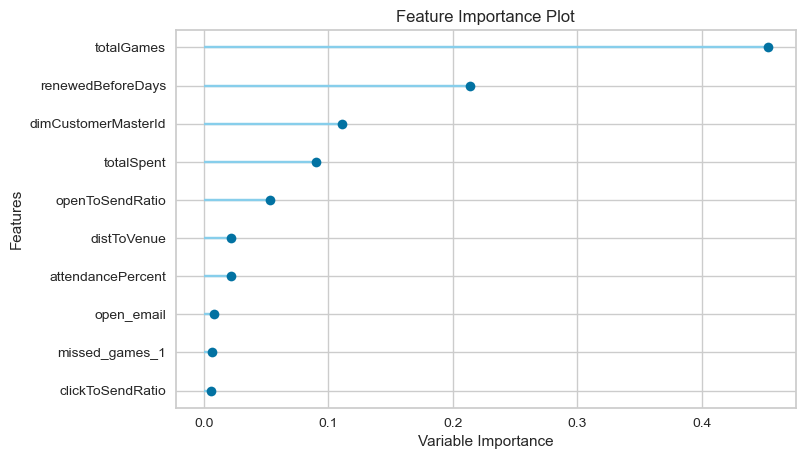

In [15]:
plot_model(best_model, plot='feature')

In [21]:
plot_model(best_model, plot='confusion_matrix')

IntProgress(value=0, description='Processing: ', max=5)

Finished loading model, total used 100 iterations


AttributeError: 'Pipeline' object has no attribute 'fig'

## Conclusions
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?